# Task 3 — Edge Detection

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float32

# ========= CONFIG =========

In [2]:
IMG_PATH = "../img/car.jpg"  
SAVE_OUTPUTS = True
OUT_DIR = "task3_outputs"
BORDER = "reflect"            
EDGE_THRESHOLD = None        

os.makedirs(OUT_DIR, exist_ok=True)

# ---- Load image -> grayscale float32 in [0,1] ----

In [3]:
im = io.imread(IMG_PATH)
if im.ndim == 3:
    im = color.rgb2gray(im)
im = img_as_float32(im)

# ---- Padding util ----

In [4]:
def pad2d(x, pad_y, pad_x, mode="reflect"):
    if mode == "constant":
        return np.pad(x, ((pad_y, pad_y), (pad_x, pad_x)), mode="constant", constant_values=0.0)
    if mode == "replicate":
        return np.pad(x, ((pad_y, pad_y), (pad_x, pad_x)), mode="edge")
    return np.pad(x, ((pad_y, pad_y), (pad_x, pad_x)), mode="reflect")

# ---- Manual 2D CORRELATION (no kernel flip) ----

In [5]:
def corr2d_manual(img, kernel, border="reflect"):
    ky, kx = kernel.shape
    assert ky % 2 == 1 and kx % 2 == 1, "Kernel size must be odd."
    py, px = ky // 2, kx // 2
    padded = pad2d(img, py, px, mode=border)
    H, W = img.shape
    out = np.zeros_like(img, dtype=np.float32)
    for y in range(H):
        ys = y
        for x in range(W):
            xs = x
            patch = padded[ys:ys+ky, xs:xs+kx]
            out[y, x] = float(np.sum(patch * kernel))
    return out

# ---- Kernels (correlation form, matching OpenCV/typical definitions) ----

In [6]:
# Prewitt
prewitt_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]], dtype=np.float32)
prewitt_y = np.array([[ 1,  1,  1],
                      [ 0,  0,  0],
                      [-1, -1, -1]], dtype=np.float32)

# Sobel
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)
sobel_y = np.array([[ 1,  2,  1],
                    [ 0,  0,  0],
                    [-1, -2, -1]], dtype=np.float32)

# ---- Manual gradients ----

In [7]:
gx_prew = corr2d_manual(im, prewitt_x, border=BORDER)
gy_prew = corr2d_manual(im, prewitt_y, border=BORDER)
mag_prew = np.hypot(gx_prew, gy_prew).astype(np.float32)
ori_prew = (np.degrees(np.arctan2(gy_prew, gx_prew)) + 360.0) % 360.0  # gradient direction [0,360)
edge_ori_prew = (ori_prew + 90.0) % 180.0  # edge orientation (perpendicular to gradient), [0,180)

gx_sob = corr2d_manual(im, sobel_x, border=BORDER)
gy_sob = corr2d_manual(im, sobel_y, border=BORDER)
mag_sob = np.hypot(gx_sob, gy_sob).astype(np.float32)
ori_sob = (np.degrees(np.arctan2(gy_sob, gx_sob)) + 360.0) % 360.0
edge_ori_sob = (ori_sob + 90.0) % 180.0

# ---- Simple edge maps via magnitude threshold ----

In [8]:
def binarize_edges(mag, thresh=None):
    t = np.percentile(mag, 90.0) if thresh is None else float(thresh)
    return (mag >= t).astype(np.uint8) * 255, t

edges_prew, t_prew = binarize_edges(mag_prew, EDGE_THRESHOLD)
edges_sob,  t_sob  = binarize_edges(mag_sob, EDGE_THRESHOLD)

# ---- Visualize & Save (single figure each) ----

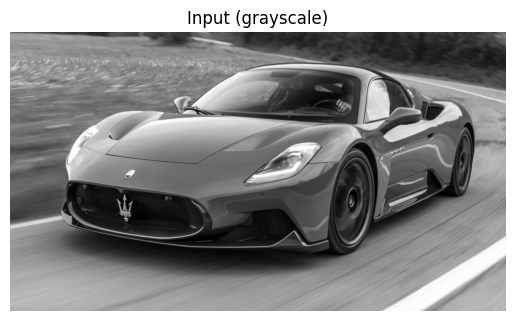

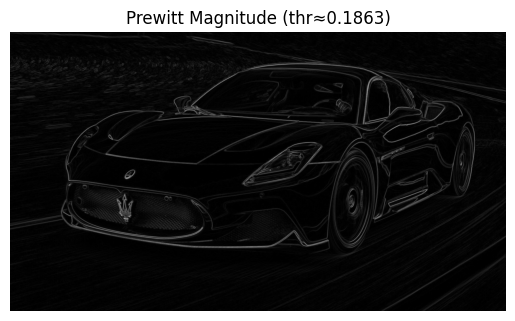

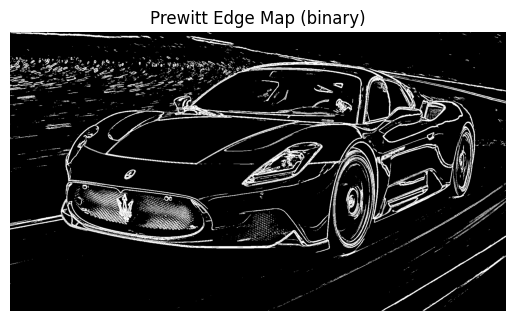

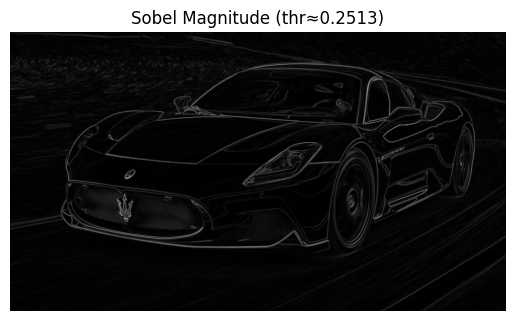

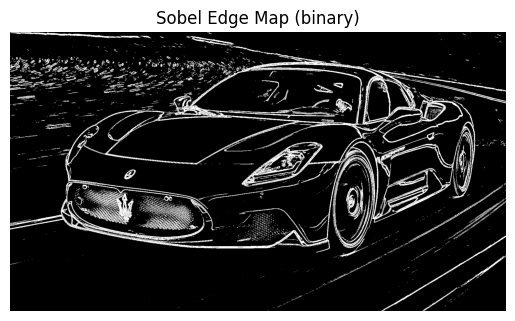

In [9]:
def show_save(img, title, fname):
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    if SAVE_OUTPUTS:
        plt.savefig(os.path.join(OUT_DIR, fname), bbox_inches="tight", pad_inches=0)
    plt.show()

show_save(im, "Input (grayscale)", "input.png")
show_save(mag_prew, f"Prewitt Magnitude (thr≈{t_prew:.4f})", "prewitt_magnitude.png")
show_save(edges_prew, "Prewitt Edge Map (binary)", "prewitt_edges.png")
show_save(mag_sob, f"Sobel Magnitude (thr≈{t_sob:.4f})", "sobel_magnitude.png")
show_save(edges_sob, "Sobel Edge Map (binary)", "sobel_edges.png")

# Orientation maps (display in [0,180) for edges)

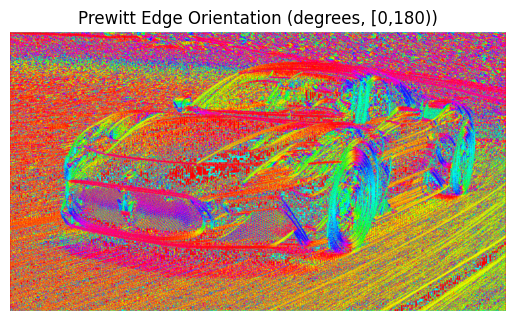

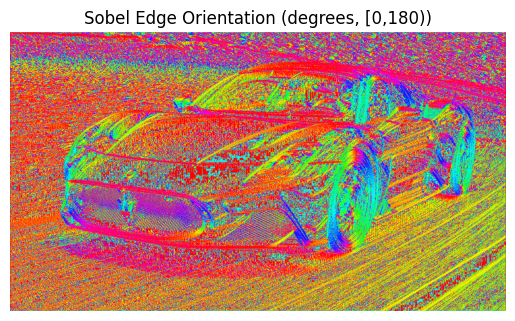

In [10]:
plt.figure()
plt.imshow(edge_ori_prew, cmap="hsv", vmin=0, vmax=180)
plt.title("Prewitt Edge Orientation (degrees, [0,180))")
plt.axis("off")
if SAVE_OUTPUTS:
    plt.savefig(os.path.join(OUT_DIR, "prewitt_edge_orientation.png"), bbox_inches="tight", pad_inches=0)
plt.show()

plt.figure()
plt.imshow(edge_ori_sob, cmap="hsv", vmin=0, vmax=180)
plt.title("Sobel Edge Orientation (degrees, [0,180))")
plt.axis("off")
if SAVE_OUTPUTS:
    plt.savefig(os.path.join(OUT_DIR, "sobel_edge_orientation.png"), bbox_inches="tight", pad_inches=0)
plt.show()

# ---- Comparison with OpenCV ----

In [11]:
# Sobel via OpenCV
gx_sob_cv = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REFLECT)
gy_sob_cv = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REFLECT)
mag_sob_cv = np.hypot(gx_sob_cv, gy_sob_cv).astype(np.float32)

mae_gx = float(np.mean(np.abs(gx_sob - gx_sob_cv)))
mae_gy = float(np.mean(np.abs(gy_sob - gy_sob_cv)))
mae_mag = float(np.mean(np.abs(mag_sob - mag_sob_cv)))
print(f"[Compare Sobel] MAE gx={mae_gx:.6f} | gy={mae_gy:.6f} | mag={mae_mag:.6f}")

# Prewitt via OpenCV (using filter2D with our kernels)
gx_prew_cv = cv2.filter2D(im, -1, prewitt_x, borderType=cv2.BORDER_REFLECT)
gy_prew_cv = cv2.filter2D(im, -1, prewitt_y, borderType=cv2.BORDER_REFLECT)
mag_prew_cv = np.hypot(gx_prew_cv, gy_prew_cv).astype(np.float32)

mae_gx_p = float(np.mean(np.abs(gx_prew - gx_prew_cv)))
mae_gy_p = float(np.mean(np.abs(gy_prew - gy_prew_cv)))
mae_mag_p = float(np.mean(np.abs(mag_prew - mag_prew_cv)))
print(f"[Compare Prewitt] MAE gx={mae_gx_p:.6f} | gy={mae_gy_p:.6f} | mag={mae_mag_p:.6f}")

[Compare Sobel] MAE gx=0.000022 | gy=0.175382 | mag=0.000035
[Compare Prewitt] MAE gx=0.000018 | gy=0.000037 | mag=0.000027


# Visualize OpenCV magnitudes

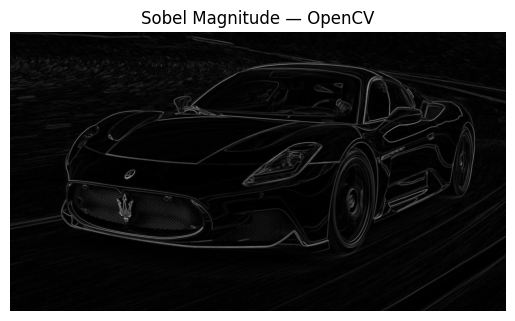

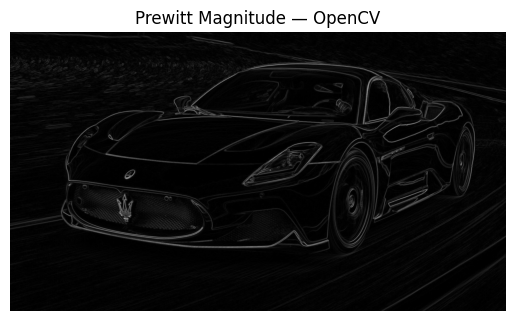


--- Gradient vs Edge Orientation (for report) ---
Let I(x,y) be the image and ∇I = (Gx, Gy) the gradient. The gradient direction θ = atan2(Gy, Gx) points toward the direction of maximum increase of intensity. An ideal edge is normal to the gradient; therefore the edge orientation φ is perpendicular to θ, i.e., φ = (θ + 90°) mod 180°. We compute θ from Sobel/Prewitt responses and report φ in [0,180).



In [12]:
show_save(mag_sob_cv, "Sobel Magnitude — OpenCV", "sobel_magnitude_opencv.png")
show_save(mag_prew_cv, "Prewitt Magnitude — OpenCV", "prewitt_magnitude_opencv.png")

# ---- Derivation note (for your report; also print here) ----
derivation = (
    "Let I(x,y) be the image and ∇I = (Gx, Gy) the gradient. The gradient direction θ = atan2(Gy, Gx) "
    "points toward the direction of maximum increase of intensity. An ideal edge is normal to the gradient; "
    "therefore the edge orientation φ is perpendicular to θ, i.e., φ = (θ + 90°) mod 180°. "
    "We compute θ from Sobel/Prewitt responses and report φ in [0,180)."
)
print("\n--- Gradient vs Edge Orientation (for report) ---\n" + derivation + "\n")

# ---- BONUS: Canny detector with threshold analysis ----

Canny t1= 30, t2=100 -> edge%=4.47


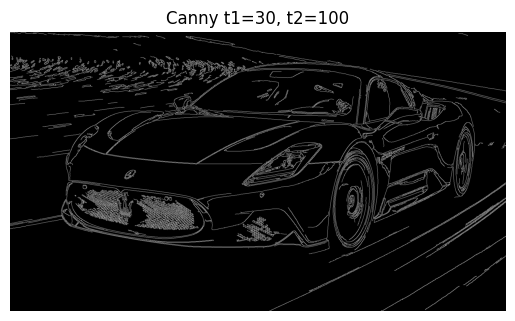

Canny t1= 30, t2=150 -> edge%=3.14


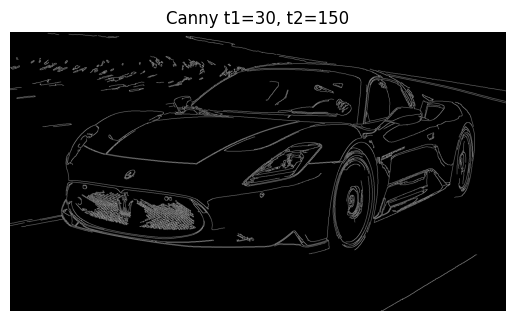

Canny t1= 30, t2=200 -> edge%=2.41


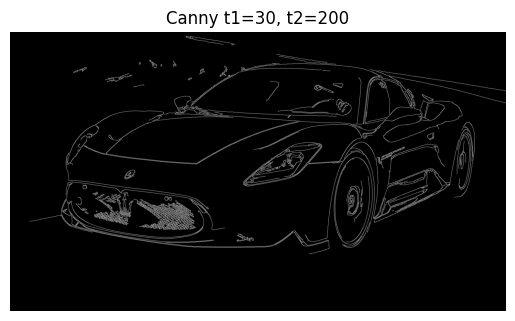

Canny t1= 60, t2=100 -> edge%=3.58


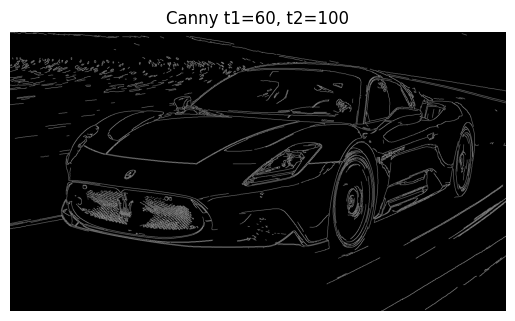

Canny t1= 60, t2=150 -> edge%=2.67


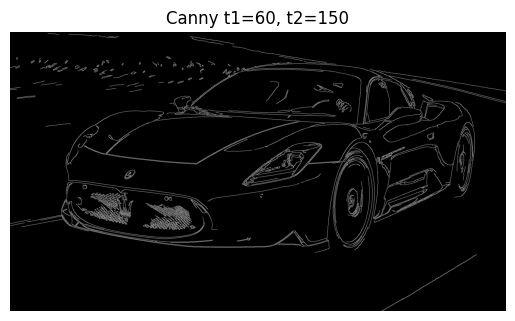

Canny t1= 60, t2=200 -> edge%=1.95


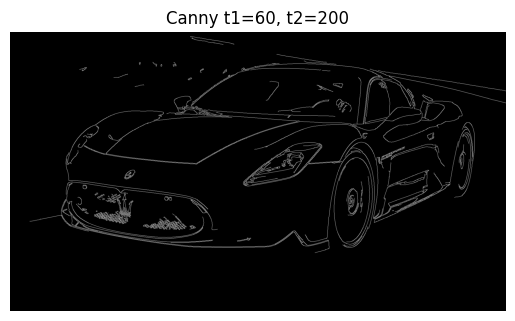

Canny t1= 90, t2=100 -> edge%=2.83


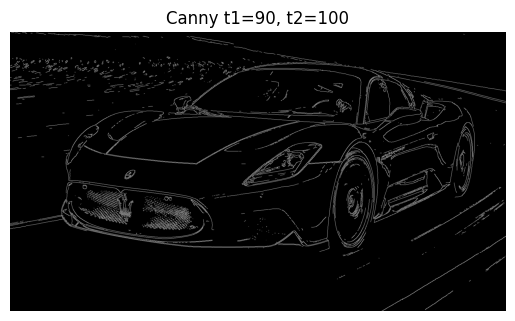

Canny t1= 90, t2=150 -> edge%=2.24


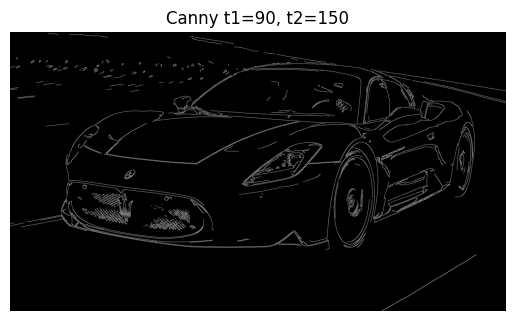

Canny t1= 90, t2=200 -> edge%=1.72


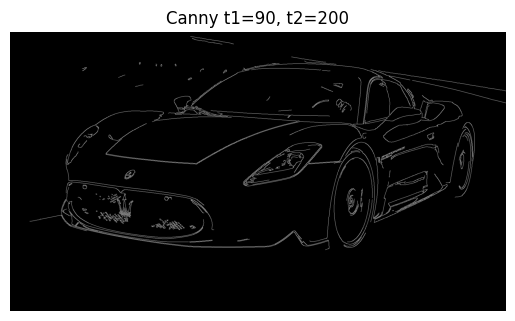

In [13]:
img_u8 = (im*255).astype(np.uint8)
for t1 in (30, 60, 90):
    for t2 in (100, 150, 200):
        ed = cv2.Canny(img_u8, t1, t2, L2gradient=True)
        ratio = np.count_nonzero(ed) / ed.size
        print(f"Canny t1={t1:>3}, t2={t2:>3} -> edge%={ratio*100:.2f}")
        show_save(ed, f"Canny t1={t1}, t2={t2}", f"canny_{t1}_{t2}.png")
